In [1]:
import sys
sys.path.append('C:\\Users\\Jacob\\Dropbox\\0DOWELL\\rnap_model\\LIET\\')
from rnap_lib_LIET_class import LIET
import rnap_lib_data_proc as dp
import rnap_lib_data_sim as ds
import rnap_lib_fitting_results as fr
import rnap_lib_plotting as lp

import matplotlib.pyplot as plt

import pymc3 as pm
import numpy as np
import scipy as sp
bgstart = ['chr1', 0, 0, 0]

import scipy.stats as stats

# Define annotation and extract read data

In [2]:
annot1 = {'gene_id': 'gene1', 'chrom': 'chr1', 'start': 1000, 'stop': 2000, 'strand': '+'}
annot2 = {'gene_id': 'gene2', 'chrom': 'chr1', 'start': 11000, 'stop': 12000, 'strand': '+'}
annot3 = {'gene_id': 'gene3', 'chrom': 'chr2', 'start': 1000, 'stop': 2000, 'strand': '-'}

annot = annot1
pad = (1000, 1000)
#pad = (1000, 2000)
rng = dp.pad_calc(annot['start'], annot['stop'], annot['strand'], pad)
dif = annot['stop'] - annot['start']
positions = np.array(range(rng[0], rng[1]))


bgfile = 'C:\\Users\\Jacob\\Dropbox\\0DOWELL\\rnap_model\\LIET\\test_bg.txt'

with open(bgfile, 'r') as bg:
    read_data = dp.bgreads(bg, bgstart, annot['chrom'], rng[0], rng[1])

preads = dp.reads_d2l(read_data[1])
nreads = dp.reads_d2l(read_data[2])                                   
                                              
data = {
    'positions': positions,
    'pos_reads': preads,
    'neg_reads': nreads,
    'pad': pad
}

# Plot the data

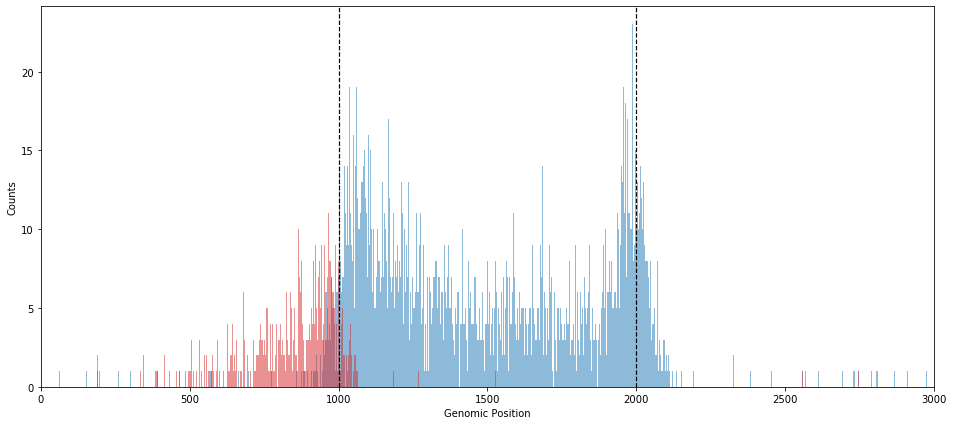

In [3]:
bins = np.linspace(0, 3000, 1500)
#bins = np.linspace(10000, 13000, 1500)
fig = plt.figure(figsize=[16,7])
ax = fig.add_subplot(111)
ax.hist(data['pos_reads'], bins=bins, alpha=0.5, density=False, color='C0');
ax.hist(data['neg_reads'], bins=bins, alpha=0.5, density=False, color='C3');
ax.axvline(x=annot['start'], ymin=0, ymax=1, linestyle='--', linewidth=1.2, color='k');
ax.axvline(x=annot['stop'], ymin=0, ymax=1, linestyle='--', linewidth=1.2, color='k');
ax.set_xlim([0,3000]);
#ax.set_xlim([10000, 13000]);
ax.set_xlabel('Genomic Position');
ax.set_ylabel('Counts');

# Instantiate the model, load annotations and data

In [4]:
liet = LIET()
liet.load_annotation(**annot)
liet.load_seq_data(**data)

# Define your priors

Have 5 parameters on the sense-strand and 3 parameters on the anti-sense strand for which we must define priors:

* Sense strand:
    - `mL` = Loading position
    - `sL` = Uncertainty on loading position
    - `tI` = Initiation length
    - `mT` = Termination position
    - `sT` = Uncertainty on termination position


* Anti-sense strand:
    - `mL_a` = Loading position
    - `sL_a` = Uncertainty on loading position
    - `tI_a` = Initiation length
    
    
Each parameter can have one of the following distributions as their prior:
* `uniform`

(must define `lower` and `upper` bounds)
* `normal`    

(must define mean `mu` and stdev `sigma`)
* `exponential`   

(must define inverse length `lambda` and zero-point `offset`)
* `wald`   

(must define mean `mu`, shape `lambda`, and zero-point `alpha`)
* `constant`   

(must define value `const`)

In [14]:
t = 250
diff = annot['stop'] - annot['start']
priors = {
    'mL': {'dist': 'uniform', 'lower': -t, 'upper': t}, 
    'sL': {'dist': 'uniform', 'lower': 30, 'upper': 500}, 
    'tI': {'dist': 'uniform', 'lower': 30, 'upper': 500}, 
    'mT': {'dist': 'uniform', 'lower': diff - t, 'upper': diff + t},    
    #'mT': {'dist': 'uniform', 'lower': diff - 0.5*t, 'upper': diff + 3*t},
    'sT': {'dist': 'uniform', 'lower': 30, 'upper': 100}, 
    'w': {'dist': 'dirichlet', 'alpha_LI': 1, 'alpha_E': 1, 'alpha_T': 1, 'alpha_B': 1},
    'mL_a': {'dist': 'uniform', 'lower': -t, 'upper': t},
    'sL_a': {'dist': 'uniform', 'lower': 30, 'upper': 100},
    'tI_a': {'dist': 'uniform', 'lower': 100, 'upper': 200}, 
}

liet.set_priors(**priors)

# Build your model and double check priors

In [15]:
liet.build_model(antisense=True, background=True)

liet.model

# Define your fit parameters and run fit

In [16]:
fit_dict = {
    'method': 'advi',
    'optimizer':'adam',
    'learning_rate':1.0,
    'iterations':2000,
    'start':None,
    'tolerance':1e-5,
    'param_tracker':True
}

inference = fr.vi_fit(liet.model, **fit_dict)

Average Loss = 32,028: 100%|███████████████| 2000/2000 [00:24<00:00, 80.95it/s]
Finished [100%]: Average Loss = 32,025


# Check convergence

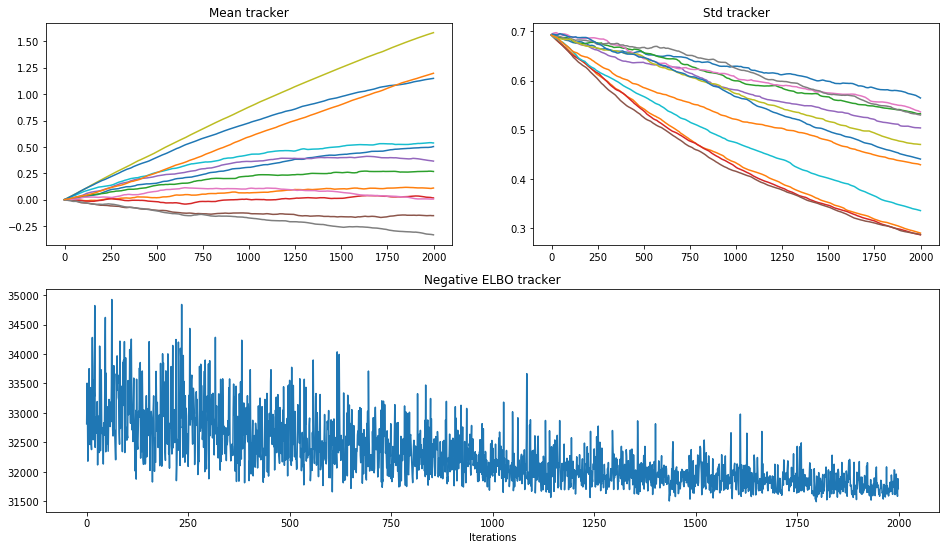

In [8]:
conv_plot = lp.convergence_plot(inference=inference['vi'], tracker=inference['tracker'])

# Summarize fit results and plot "best fit"

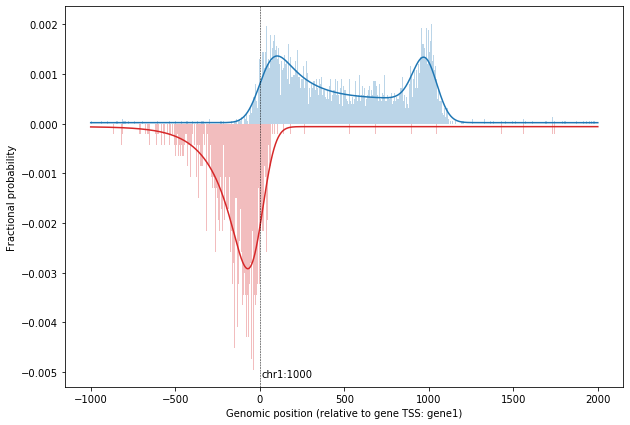

In [9]:
post_stats = fr.posterior_stats(inference['approx'], calc_mean=True, calc_stdev=True)
liet.results.update(post_stats)

bins = np.linspace(-1000, 2000, 500)
plot = lp.LIET_plot(liet, bins=bins, antisense=True)

# Record best fit parameter values

In [23]:
print("\tMean\t\t\tStdev")
print("----------------------------------------")
for p, st in post_stats.items():
    if p[0] == 'w':
        print(f"{p}\t{np.round(st['mean'], 2)}\t\t{np.round(st['stdev'], 2)}")
    else:
        print(f"{p}\t{np.round(st['mean'], 2)}\t\t\t{np.round(st['stdev'], 2)}")

	Mean			Stdev
----------------------------------------
mL	2.14			5.21
sL	52.2			3.3
tI	161.35			8.23
mT	997.3			4.21
sT	48.62			2.0
w	[0.35 0.46 0.17 0.03]		[0.01 0.01 0.01 0.  ]
mL_a	0.27			4.98
sL_a	48.05			3.61
tI_a	153.36			6.01
w_a	[0.98 0.02]		[0.01 0.01]


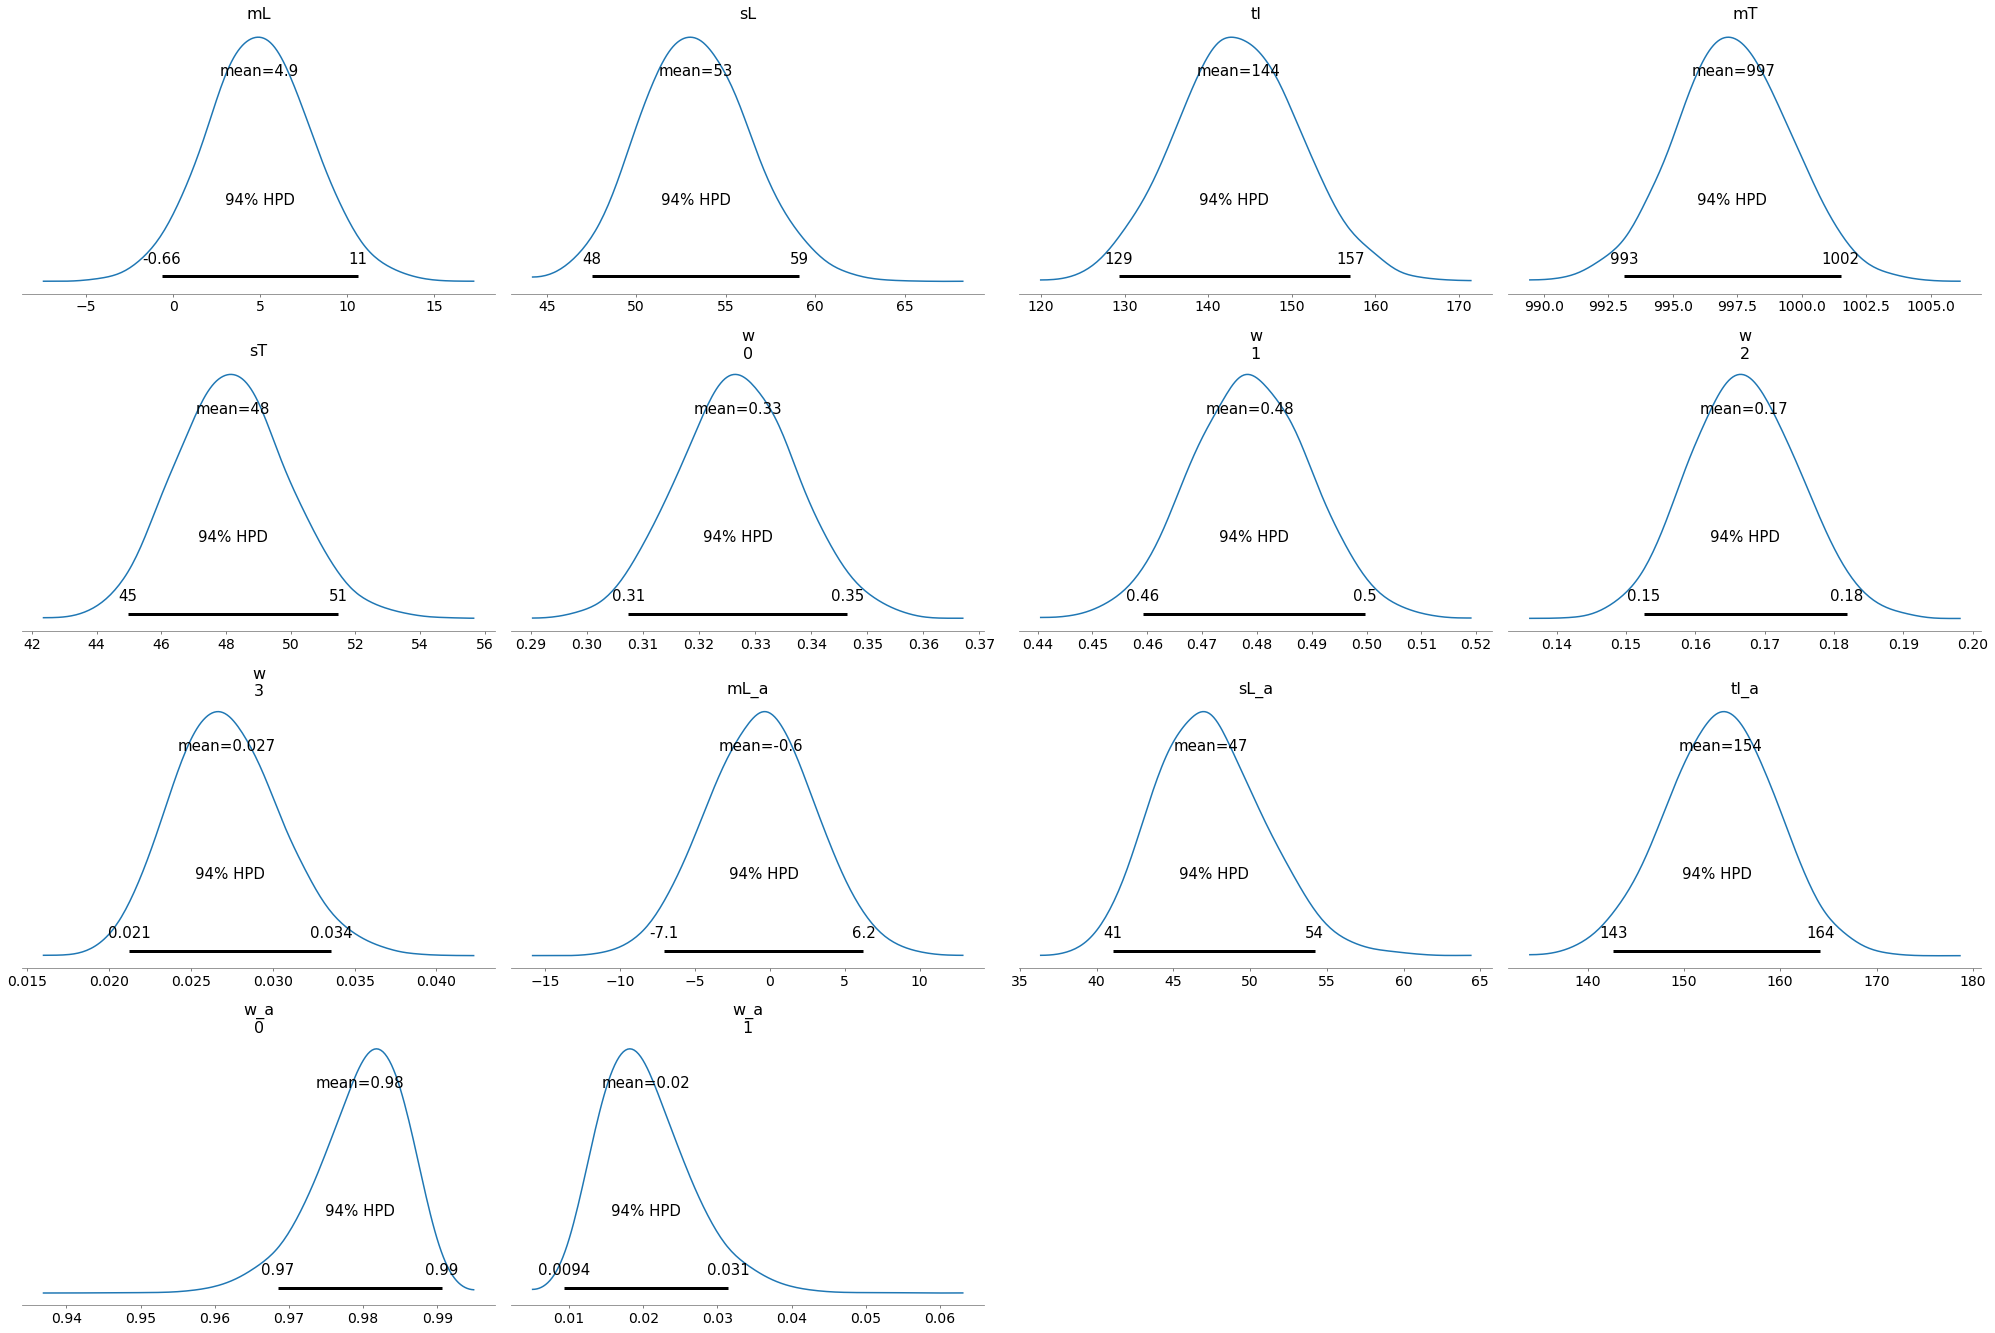

In [60]:
pm.plot_posterior(inference['approx'].sample(10000));